In [2]:
# ==== Import Packages ====

from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
from tkinter.filedialog import askopenfilename

import numpy as np
import glob 

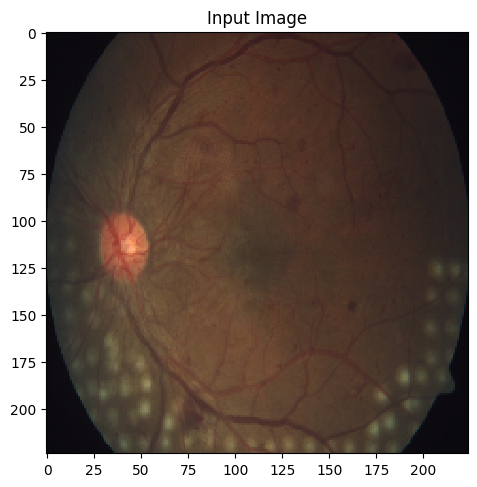

In [3]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

I = imread("/content/drive/MyDrive/drdataset/Proliferate_DR/0bf37ca3156a.png")
imshow(I)
plt.title('Input Image')
plt.show()


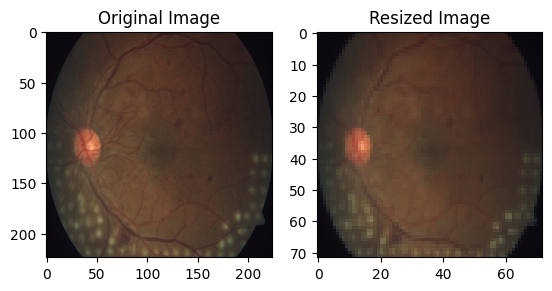

In [4]:
from skimage.transform import resize
import matplotlib.pyplot as plt

img_resize_orig = resize(I, (72, 72))

plt.subplot(1, 2, 1)
plt.imshow(I)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_resize_orig)
plt.title('Resized Image')

plt.show()

In [5]:
# ==== Image Splitting ====
    
import os

test_data1=os.listdir('/content/drive/MyDrive/drdataset/Mild')

test_data2=os.listdir('/content/drive/MyDrive/drdataset/Moderate')

test_data3=os.listdir('/content/drive/MyDrive/drdataset/Normal')

test_data4=os.listdir('/content/drive/MyDrive/drdataset/Proliferate_DR')

test_data5=os.listdir('/content/drive/MyDrive/drdataset/Severe')

dot=[]
labels_val=[]



for img in test_data1:
    try:
        img_1=imread('/content/drive/MyDrive/drdataset/Mild/'+'/'+img)
        img_resize=resize(img_1,(72,72))
        dot.append(np.array(img_resize))
        labels_val.append(1)
    except:
        None


for img in test_data2:
    try:
        img_1=imread('/content/drive/MyDrive/drdataset/Moderate/'+'/'+img)
        img_resize=resize(img_1,(72,72))
        dot.append(np.array(img_resize))
        labels_val.append(2)
    except:
        None

for img in test_data3:
    try:
        img_1=imread('/content/drive/MyDrive/drdataset/Normal/'+'/'+img)
        img_resize=resize(img_1,(72,72))
        dot.append(np.array(img_resize))
        labels_val.append(3)
    except:
        None


for img in test_data4:
    try:
        img_1=imread('/content/drive/MyDrive/drdataset/Proliferate_DR/'+'/'+img)
        img_resize=resize(img_1,(72,72))
        dot.append(np.array(img_resize))
        labels_val.append(4)
    except:
        None


for img in test_data5: 
    try:
        img_1=imread('/content/drive/MyDrive/drdataset/Severe/'+'/'+img)
        img_resize=resize(img_1,(72,72))
        dot.append(np.array(img_resize))
        labels_val.append(5)
    except:
        None

In [6]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.9 MB/s eta 0:00:00


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dot,labels_val,test_size = 0.2, random_state = 101)

print()
print("-------------------------------------")
print("       IMAGE SPLITTING               ") 
print("-------------------------------------")
print()


print("Total no of data        :",len(dot))
print("Total no of training data   :",len(x_train))
print("Total no of testing data  :",len(x_test))


-------------------------------------
       IMAGE SPLITTING               
-------------------------------------

Total no of data        : 2106
Total no of training data   : 1684
Total no of testing data  : 422


In [9]:
from keras.utils import to_categorical


y_train1=np.array(y_train)
y_test1=np.array(y_test)

train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)




x_train2=np.zeros((len(x_train),72,72,3))
for i in range(0,len(x_train)):
        x_train2[i,:,:,:]=x_train2[i]

x_test2=np.zeros((len(x_test),72,72,3))
for i in range(0,len(x_test)):
        x_test2[i,:,:,:]=x_test2[i]

In [10]:
x_train2.shape

(1684, 72, 72, 3)

In [11]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train2)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


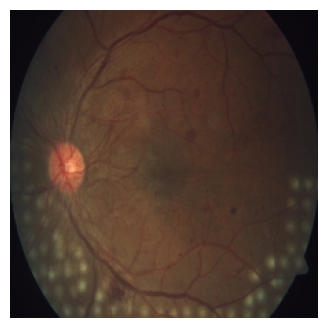

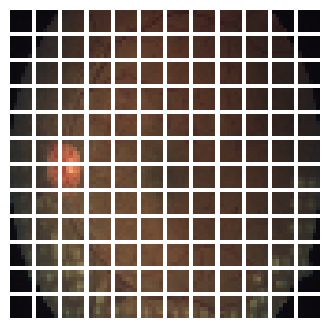

In [15]:
#display patches for an image
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = I
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
#build ViT model
input_shape=(72, 72, 3)
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(8)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.categorical_crossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    #history = model.fit(
        #x=x_train2,
        #y=train_Y_one_hot,
        #batch_size=batch_size,
        #epochs=num_epochs,
        #validation_split=0.1,
        #callbacks=[checkpoint_callback],
    #)

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test2, test_Y_one_hot)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history



In [19]:
y_train1=np.array(y_train)
y_test1=np.array(y_test)

train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

# ... (code for image splitting and preprocessing)

# ... (code for defining the ViT model)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(dot, labels_val, test_size=0.2, random_state=101)

# Convert labels to one-hot encoded format
y_train1 = np.array(y_train)
y_test1 = np.array(y_test)
train_Y_one_hot = tf.keras.utils.to_categorical(y_train1)
test_Y_one_hot = tf.keras.utils.to_categorical(y_test1)

# Run the experiment using the ViT model
model = create_vit_classifier()
#history = run_experiment(model)


In [21]:
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
# from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dropout


# initialize the model
model=Sequential()


#CNN layers 
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(72,72,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(500,activation="relu"))

model.add(Dropout(0.2))

model.add(Dense(6,activation="softmax"))

#summary the model 
model.summary()

#compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam')
y_train1=np.array(y_train)

from keras.utils import to_categorical

train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)


print("-------------------------------------")
print("CONVOLUTIONAL NEURAL NETWORK (CNN)")
print("-------------------------------------")
print()


x_train2=np.zeros((len(x_train),72,72,3))
for i in range(0,len(x_train)):
        x_train2[i,:,:,:]=x_train2[i]

x_test2=np.zeros((len(x_test),72,72,3))
for i in range(0,len(x_test)):
        x_test2[i,:,:,:]=x_test2[i]


#fit the model 
history=model.fit(x_train2,train_Y_one_hot,batch_size=2,epochs=1,verbose=1)
loss=history.history['loss']
loss=max(loss)

acc_dl=100-loss

print("--------------------------------")
print("ACCURACY FOR DEEP LEARNING")
print("--------------------------------")
print()
print("1. Accuracy  =",acc_dl,'%')
print()
print("2.Error Rate =",loss,'%')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 72, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0

In [22]:
# prediction

Total_length = len(test_data1) +  len(test_data2) + len(test_data3) +  len(test_data4) + len(test_data5)

temp_data1  = []

for ijk in range(0,Total_length):
    # print(ijk)
    temp_data = int(np.mean(dot[ijk]) == np.mean(img_resize_orig))
    temp_data1.append(temp_data)

temp_data1 =np.array(temp_data1)

zz = np.where(temp_data1==1)
print(zz)


(array([1751]),)


In [23]:
print("-------------")
print("PREDICTION")
print("-------------")

if labels_val[zz[0][0]] == 1:
  print('Identified = MILD - Grade A')
 
elif labels_val[zz[0][0]] == 2:
    print('Identified = MODERATE - Grade B')

elif labels_val[zz[0][0]] == 3:
    print('Identified = NORMAL ')

elif labels_val[zz[0][0]] == 4:
    print('Identified = PROLIFERATE - Grade C ')

elif labels_val[zz[0][0]] == 5:
    print('Identified = SEVERE - Grade D')

-------------
PREDICTION
-------------
Identified = PROLIFERATE - Grade C 
